# REPRESENTATION OF ARABS IN IN CINEMA BEFORE AND AFTER 2001
Here, we present a pipeline of cleaning, filtering and first analysis of the CMU dataset. We at first, we analyse the character etnicity and yearly numbers for characters. Then, we select only characters from the western world and do a first study on the genres. The study is directed to the plot study, using characher recognition to prepare the NLP analysis.

# Cleaning data

In [1]:
# libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
import spacy
import ast
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
import statsmodels.formula.api as smf
import networkx as nx
# Téléchargez les stopwords s'ils ne sont pas déjà téléchargés
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/omed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Ignoring minor warnings
warnings.filterwarnings("ignore")

In [3]:
# folders of imported files
folder_std = r'./MovieSummaries'
folder_add = r'./Added_df'

In [4]:
# import data. We will use the movie.metadata.tsv file
col_names = ['wikiID','freeID','movie_name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv(folder_std + "/movie.metadata.tsv",sep='\t',names=col_names)
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
# the column release date is set to be a datetime object. We have two different formats. we solve this using a mask
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date

In [6]:
# Convert the countries, genres and languages columns to a list of countries
movies['countries'] = movies['countries'].apply(lambda x: list(json.loads(x).values()))
movies['genres'] = movies['genres'].apply(lambda x: list(json.loads(x).values()))
movies['languages'] = movies['languages'].apply(lambda x: list(json.loads(x).values()))
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


This is the movies Dataframe we will use for the rest of the project.

# Movies per year

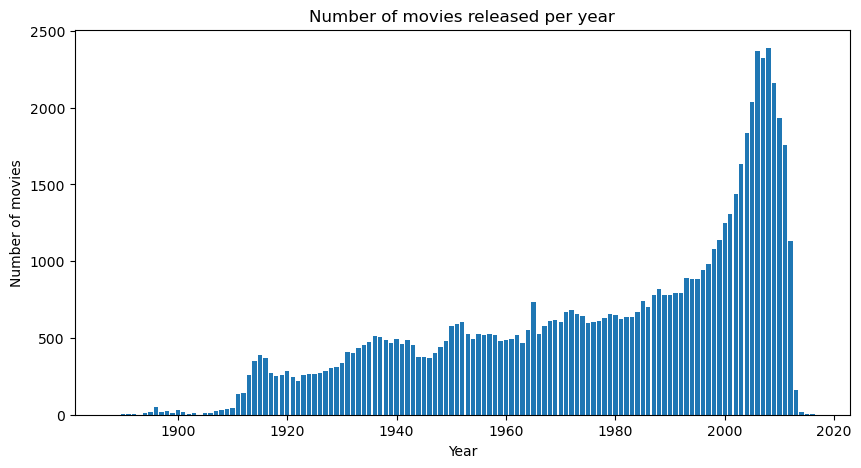

In [7]:
# we want to plot the number of movies released per year
# we group by year and count the number of movies
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count().reset_index(name='count')


# plot the number of movies per year
plt.figure(figsize=(10,5))
plt.bar(yearly_movies['release_date'],yearly_movies['count'])
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [8]:
# we want to know how many movies were released before and after the year 2001, since this is the year of the twin towers attack
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')
print(f'The ratio of movies after the year 2001 is {count_after2001/(count_after2001+ count_before2001):.2}')  

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
The ratio of movies after the year 2001 is 0.31


The twin tower event has a relevant amount of films before (arounf 69%) and after (31%). This is a first sign that we can work analysing it through movies. 

Now, to really study arab actors, we read the actors df and work on the ethnicities.

# Ethnicity analysis

First of all, it is interesting to understand the ethnicity distribution of actors in the movies.

In [9]:
# Read the character.metadata.tsv file
col_names = ['wikiID','freeID','release_date','character_name','birth','gender','height','ethnicity_code', 'actor_name', 'age_at_release', 'freeID_character_actor_map', 'freeID_character', 'freeID_actor']
characters= pd.read_csv(open(folder_std + "/character.metadata.tsv",encoding='utf-8'), delimiter="\t", names=col_names)

characters.head()

,wikiID,freeID,release_date,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We merge movies and character dataframes by using the freeID and wikiID, (identifiers for movies) as keys.

In [10]:
# Merge the two dataframes on the wikiID and freeID
movies_characters = pd.merge(movies, characters, on=['freeID', 'wikiID'], how='inner', suffixes=('', '_y'))

# We drop the duplicate columns
movies_characters=movies_characters.drop(['release_date_y'], axis=1)
movies_characters.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [11]:
# print the number of Actor ethnicities (Freebase ID)
eth_num = movies_characters['ethnicity_code'].unique().shape[0]
print(f'There are {eth_num} different ethnicities')


There are 480 different ethnicities


How to decode the Freebase ID to a precise ethnicity? We used a query command to the freebase API and got a database to work on.

In [12]:
# read the csv file where we decode the ethnicities ID
ethnicity_decode = pd.read_csv(folder_add + "/ethnicity.csv",sep=',')
ethnicity_decode.columns= ['ethnicity_code', 'ethnicity_name']
ethnicity_decode.head()

,ethnicity_code,ethnicity_name
0,/m/07s8n27,Makonde people
1,/m/02k1vf,Powhatan
2,/m/0630vt,Apalachee people
3,/m/038cy,Germanic peoples
4,/m/03gq7tt,Hän people


In [13]:
# merging the two dataframes
movies_characters_eth= pd.merge(movies_characters, ethnicity_decode, how='left', left_on=['ethnicity_code'], right_on=['ethnicity_code'])
movies_characters_eth.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN


Did the ethnicity_decode work for all the freeID?

In [14]:
# filter the movies that have an eyhnicity_code but not the ethnicity_name
not_filtered= movies_characters_eth[movies_characters_eth['ethnicity_code'].notna() * movies_characters_eth['ethnicity_name'].isna()].copy()
print(f'characters not decoded: {not_filtered.shape[0]}')
print(f'portion of characters not decoded: {not_filtered.shape[0]/movies_characters_eth.shape[0]:.2}')

eth_not_decoded=not_filtered['ethnicity_code'].unique().shape[0]

eth_not_decoded_portion= eth_not_decoded/ movies_characters_eth['ethnicity_code'].unique().shape[0]
not_filtered['ethnicity_code'].unique().shape[0]

print(f'ethnicities not decoded {eth_not_decoded}')
print(f'portion of ethnicities not decoded {eth_not_decoded_portion:.2}')

characters not decoded: 50587
portion of characters not decoded: 0.11
ethnicities not decoded 158
portion of ethnicities not decoded 0.33


A good portion of ethnicity codes is not decoded into ethnicity names (33%). However, it is visible that these ethnicities appear rarely in the dataset, as only 11% of characters with ethnicity code do not present a correspondant ethnicity name.

We want to find the distribution of ethnicities in the dataset. 

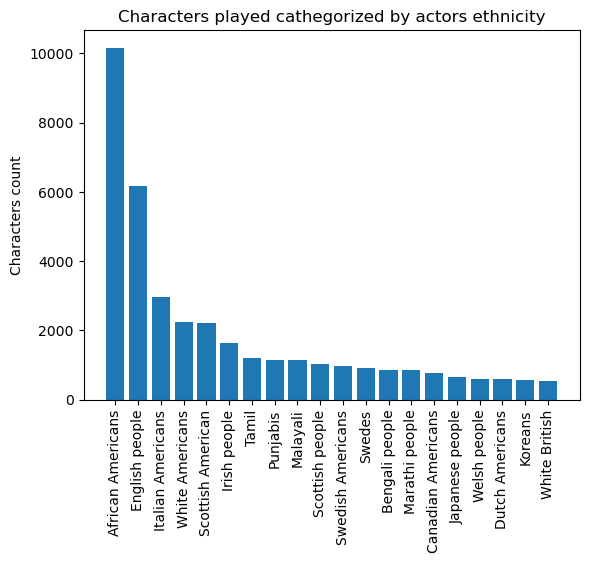

In [15]:
ethnicity_count = movies_characters_eth.groupby(movies_characters_eth['ethnicity_name'])['ethnicity_name'].count().reset_index(name = 'count')

ethnicity_count = ethnicity_count.sort_values(by='count',ascending=False)
plt.bar(ethnicity_count['ethnicity_name'].iloc[:20],ethnicity_count['count'].iloc[:20])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Characters played cathegorized by actors ethnicity')
plt.show()

In [16]:
print('In total, there are {} ethnicities of which we know the name.'.format(ethnicity_count['ethnicity_name'].shape[0]))

In total, there are 320 ethnicities of which we know the name.


To get the arabic ethnicities, we asked AI to identify ethnicities inside the list that can be considered of arabic culture. It is important to state that the arab ethnicities are really diverse and that generally anti-arab stereotypes are also linked to people of non-arab countries, but muslim. This is taken into consideration adding some ethnicities from Asia like Pakistan and Bengali.

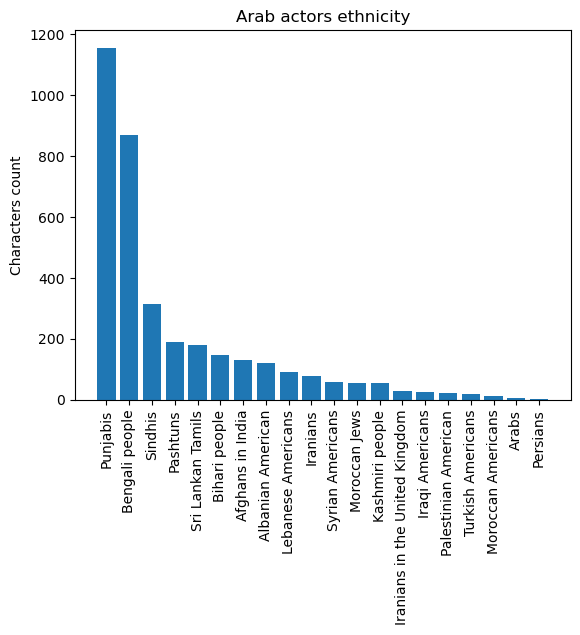

Arabic ethnicities are 20


In [17]:
# unique ethnicities
eth_unique=ethnicity_count['ethnicity_name'].unique()

# Commonly associated arab ethnicities. we used Chat GPT results
arab_ethnicities = ['Punjabis', 'Bengali people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Sindhis', 'Kashmiri people', 'Afghans in India', 'Iranians', 'Albanian American', 'Syrian Americans', 'Moroccan Jews', 'Kurdish', 'Iraqi Americans', 'Turkish Americans', 'Lebanese Americans', 'Iranians in the United Kingdom', 'Palestinian American', 'Moroccan Americans', 'Egyptian Americans', 'Libyan Americans', 'Algerian Americans', 'Tunisian Americans', 'Yemeni Americans', 'Saudi Americans', 'Omani Americans', 'Emirati Americans', 'Qatari Americans', 'Kuwaiti Americans', 'Bahraini Americans', 'Jordanian Americans', 'Palestinians', 'Rohingya people', 'Malays', 'Indonesians', 'Bangladeshis', 'Pakistanis', 'Turks', 'Persians', 'Arabs']
# manually deleted: 'Gujarati peole'
# dubious about: 'Punjabis'

# Filter ethnicities corresponding to arab people
arab_ethnicities_subset = list(np.intersect1d(eth_unique, arab_ethnicities))

# Select only the ethnicity name of eth_unique in the arab_ethnicities_subset
arab_count = ethnicity_count[ethnicity_count['ethnicity_name'].isin(arab_ethnicities)]
arab_count=arab_count.sort_values(by='count', ascending=False)
plt.bar(arab_count['ethnicity_name'],arab_count['count'])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Arab actors ethnicity')
plt.show()

# Number of Arabic ethnicities
print('Arabic ethnicities are {}'.format(len(arab_ethnicities_subset), arab_ethnicities_subset))

In [18]:
# proportion of arab characters
print(f"From the ethnicities provided, {arab_count['count'].sum()} characters over the years are classified as arab characters.")
print(f'Proportion of arab characters w.r.t. all characters is {arab_count["count"].sum()*100/ethnicity_count["count"].sum():.3}%')

From the ethnicities provided, 3551 characters over the years are classified as arab characters.
Proportion of arab characters w.r.t. all characters is 6.4%


# Arab names analysis

The main focus of our project is the character ethnicity, not the actor ethnicity, even though they are generally related. To do so, we analyse a list of commonly arab names and we check their presence in the character name column. 

By starting to filter the Dataframe for characters with a name within the list, we then filter for movies of United States and European production. Finally, we check if these character names are present in the plot, to asses the feasibility of the sentiment analysis, to be done in the following phases of the project.

A list of arab names (male and female) is retrieved from Wikipedia and is contained in the file arab_names.txt. This list is enriched by adding common AI generated adjectives which refer to the arab and muslim culture. This is done because the column characters_name uses a general description of the character when not a primary role. Also, some names where manually deleted as ambiguous and possibly having a different cultural origin.

In [19]:
# Read the file
with open(folder_add+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

In [20]:
# Function to determine if the character name is an arab name
def filter_arab_names(name):
    name = str(name).lower()
    for n in arab_names:
        if n in name.split():
            return True
        
    return False

The dataframe is filtered for what are designated as "arabic characters".

This line of code is the longest of the notebook to be executed.

In [21]:
movies_characters_ar = movies_characters_eth[movies_characters_eth['character_name'].apply(filter_arab_names)]
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,1923-11-11,M,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,1932-06-22,M,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN


In [22]:
# Examples of character names classified as arab names
movies_characters_ar['character_name']

202                        Rahim
564       I.S.I Chief Ishak Khan
798                     Amal Raj
987                Ali La Pointe
991                       Halima
                   ...          
447804             Jamal Hassani
448077                     Nader
449075          Rev. Fred Sultan
449653                Bobby Nair
450406              Prince Akeem
Name: character_name, Length: 1501, dtype: object

In [23]:
print('The number of characters with a name classified as arab is {}.'.format(movies_characters_ar['character_name'].shape[0]))

The number of characters with a name classified as arab is 1501.


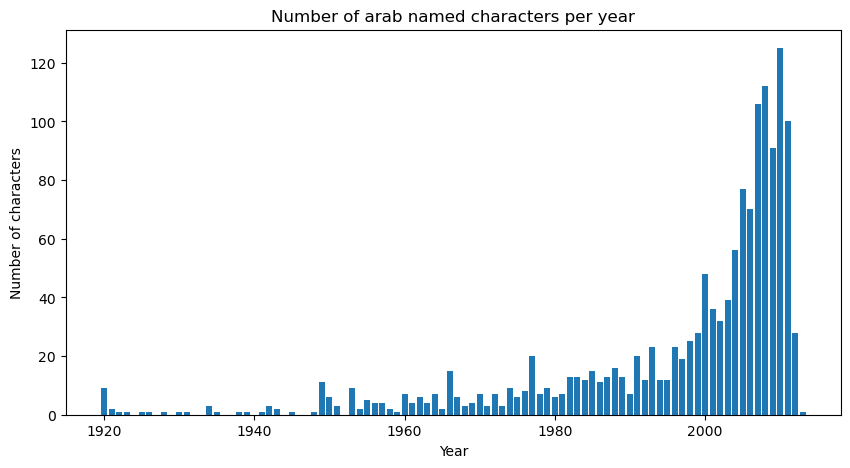

In [24]:
# How many movies with arab people per year
yearly_characters = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
yearly_characters['arabs_fraction'] = yearly_characters['arabs_count'] / movies_characters.groupby(movies_characters['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_fraction')['arabs_fraction']
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'])

plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year')
plt.show()

In [25]:
# classifying the movies as before and after 2001
count_before2001 = yearly_characters[yearly_characters['release_date']<=2001]['arabs_count'].sum()
count_after2001 = yearly_characters[yearly_characters['release_date']>2001]['arabs_count'].sum()
print(f'Arab named characters before the year 2001 are {count_before2001}')
print(f'Arab named characters after the year 2001 are {count_after2001}')
print('The total is less because some movies do not have the release date (NaN).')

Arab named characters before the year 2001 are 600
Arab named characters after the year 2001 are 837
The total is less because some movies do not have the release date (NaN).


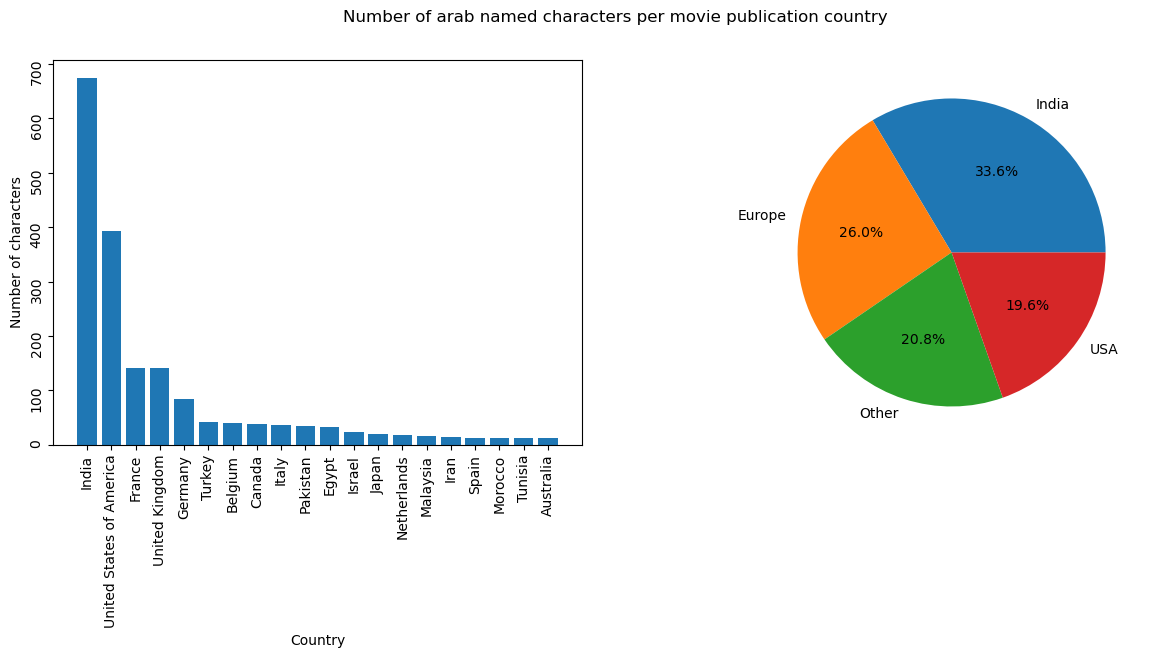

In [26]:
# Arab characters per country
exploded = movies_characters_ar.explode('countries')
country_counts = exploded['countries'].value_counts()

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(country_counts.index[:20],country_counts.values[:20])
ax[0].tick_params(labelrotation=90)
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Number of characters')
fig.suptitle('Number of arab named characters per movie publication country')

# Group USA, European countries all together, and classify the rest as 'other'
# European countries list
eu_countries = ['France','Germany','Italy','Spain','United Kingdom', 'Sweden', 'Netherlands', 'Denmark', 'Finland', 'Belgium', 'Greece', 'Austria', 'Switzerland', 'Norway', 'Ireland', 'Portugal', 'Luxembourg', 'Iceland', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Bulgaria', 'Slovakia', 'Estonia', 'Latvia', 'Lithuania', 'Croatia', 'Slovenia', 'Cyprus', 'Malta']
exploded['countries'] = exploded['countries'].apply(lambda x: 'USA' if x=='United States of America' else 'Europe' if x in eu_countries else 'India' if x=='India' else 'Other')
country_grouped_counts = exploded['countries'].value_counts()

ax[1].pie(country_grouped_counts.values,labels=country_grouped_counts.index,autopct='%1.1f%%')
plt.show()


It is visible from the histogram above how the majority of arab characters are present in Indian movies. This is because arab/muslim culture is very influent in this country, for the vicinity to Arab countries.  

European countries can be considered under the United States cultural influence. Thus, it makes sense to add them into the analysis, to extend the number of characters and have a more statistically relevant sentiment analysis.

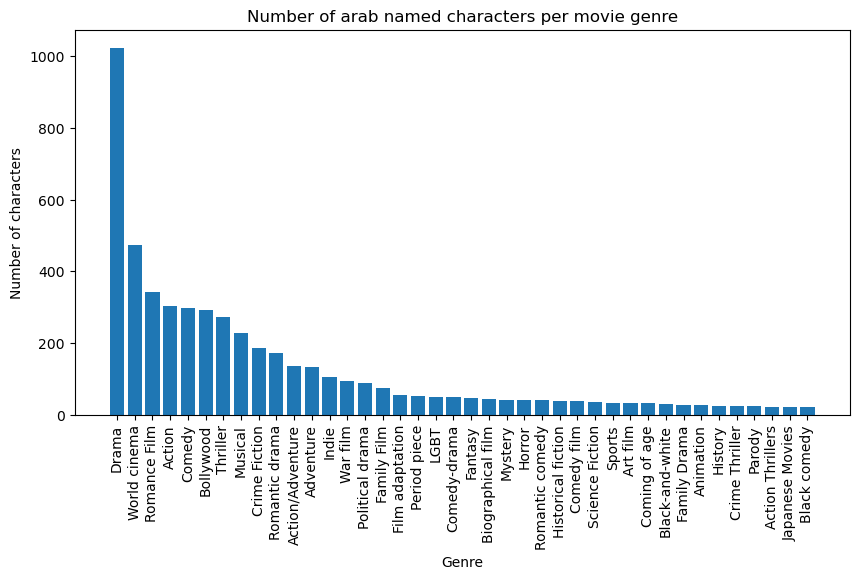

In [27]:
# Arab characters per genre
plt.figure(figsize=(10,5))
exploded = movies_characters_ar.explode('genres')
genre_counts = exploded['genres'].value_counts()
genre_counts = genre_counts.sort_values(ascending=False)
plt.bar(genre_counts.index[:40],genre_counts.values[:40])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per movie genre')
plt.show()

It is important to note that the graphs counts, both for country and genre cathegorizations, do not add up to the total number of arab characters in the Dataframe but to a larger number. This happens because some charecters are counted multiple times, as the movie they are in is classified with more than one genre or is published in more than one country. However, for our analysis it is important to have a number for the totality of each cathegories, making this graph meaningful as initial considerations before the actual project. 

As already stated, we are mainly interested in movies from USA, Canada and Europe.

In [28]:
# Filter arab movie characters from the western countries
western_countries = ['United States of America','Canada']+eu_countries

# For each character, we filter for movies pubblished in western countries
mask_characters_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_western]
mask_characters_ar_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_ar_western]
print('The total number of characters from western countries is {}.'.format(movies_characters_ar_western.shape[0]))

The total number of characters from western countries is 678.


In [29]:
# Arab movie characters from western countries count before and after 2001
yearly_characters_western = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
arab_western_before = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year<=2001].shape[0]
arab_western_after = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year>2001].shape[0]
print('The total number of characters from western countries before 2001 is {}.'.format(arab_western_before))
print('The total number of characters from western countries after 2001 is {}.'.format(arab_western_after))

The total number of characters from western countries before 2001 is 255.
The total number of characters from western countries after 2001 is 396.


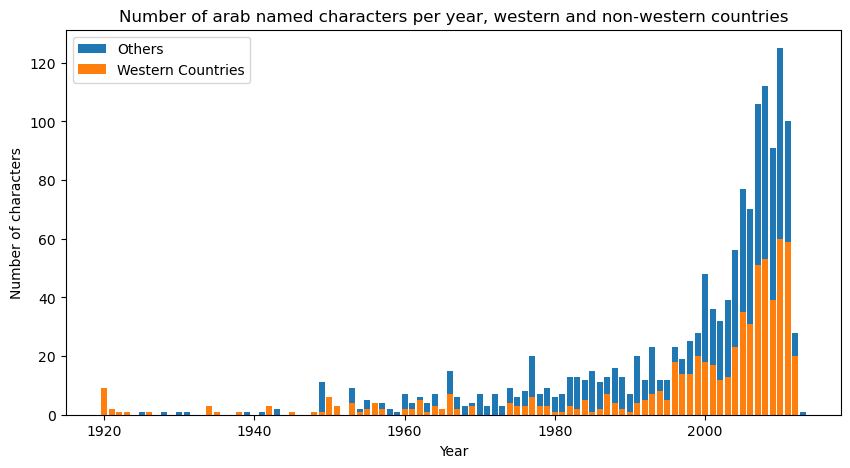

In [30]:
# Classify movies per year divided into western and non-western countries
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'],label='Others')
plt.bar(yearly_characters_western['release_date'],yearly_characters_western['arabs_count'],label='Western Countries')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year, western and non-western countries')
plt.show()

In [31]:
# view the value in the year 1980

yearly_characters.loc[yearly_characters['release_date'].isin(range(1965,1990))]

,release_date,arabs_count,arabs_fraction
33,1965.0,2,0.009709
34,1966.0,15,0.075000
35,1967.0,6,0.027907
36,1968.0,3,0.012397
37,1969.0,4,0.014493
38,1970.0,7,0.018277
39,1971.0,3,0.004823
40,1972.0,7,0.013208
41,1973.0,3,0.006289
42,1974.0,9,0.017578


## First study on the arab characters role.

Now, we want to get a first sight on the arab presence in the filmography. We are going to evaluate the genre which they play, to get an idea if 9/11 influences how many arab characters play a role linked to crime and violence. 
We select the genres Crime Fiction and War films as the ones that treat crime and violence as a theme. 

In [32]:
# First of all, we drop the rows without a release date
movies_characters = movies_characters[movies_characters['release_date'].notna()]
movies_characters_ar = movies_characters_ar[movies_characters_ar['release_date'].notna()]

In [33]:
# Also, we drop the rows without a genre
movies_characters['no_genres'] = movies_characters['genres'].apply(lambda x: 1 if x==[] else 0)
movies_characters_ar['no_genres'] = movies_characters_ar['genres'].apply(lambda x: 1 if x==[] else 0)

# Show the number of characters in a film without a genre
print('The number of movies without a genre is {}.'.format(movies_characters[movies_characters['no_genres']==1].shape[0]))
print('The number of movies without a genre is {}.'.format(movies_characters_ar[movies_characters_ar['no_genres']==1].shape[0]))
# yearly_characters = yearly_characters.merge(movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['no_genres'].sum().reset_index(name='ar_no_genres'), on='release_date', how='left')

# Drop the rows without a genre
movies_characters = movies_characters[movies_characters['no_genres']==0]
movies_characters_ar = movies_characters_ar[movies_characters_ar['no_genres']==0]


The number of movies without a genre is 3518.
The number of movies without a genre is 5.


In [34]:
# For every arab character, we indicate if they play a movie of the Crime, War Genre or not
Selected_genres = ['Crime Fiction' , 'War film'] 
# Add the column cri_and_vio_genres for the general dataframe and the specifical for arabs
movies_characters.loc[:, 'cri_and_vio_genres'] = movies_characters['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).astype(int) 
movies_characters_ar.loc[:, 'cri_and_vio_genres'] = movies_characters_ar['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).astype(int)
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,no_genres,cri_and_vio_genres
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,...,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN,0,0
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,...,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN,0,0


Now, we need to appropriately select the range of years to take in consideration for further analysis. In particular, we want to measure the genre partecipation feature for arab characters before and after 9/11. We define a starting year in the analysis 
- to limit the effect of other events in time 
- to start from years where arabs participation in movies was relevant and war and crime films were present in cinema panorama

In [35]:
# see the evolution of 'cry_and_vio_genres' over the years

cri_and_vio= movies_characters.groupby(movies_characters['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_ar = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')

Text(0.5, 1.0, 'Number of arab named characters per year in w&c movies')

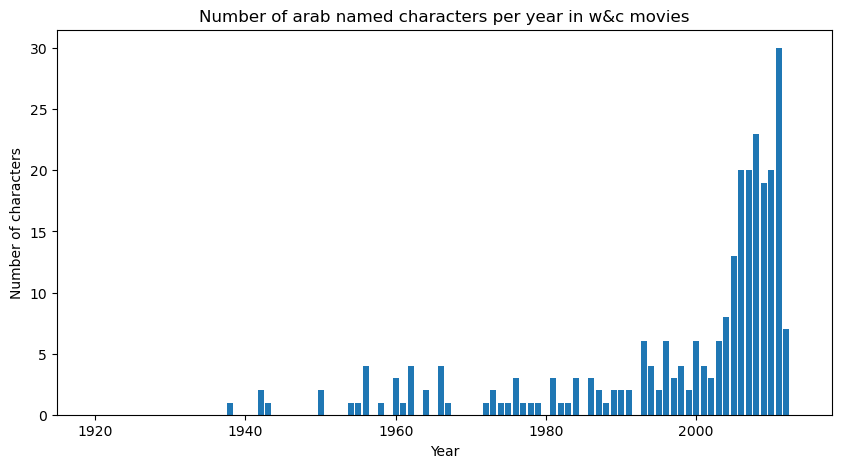

In [36]:
#plot the characters with crime and war genre per year
plt.figure(figsize=(10,5))
plt.bar(cri_and_vio_ar['release_date'],cri_and_vio_ar['count'],label='arabs')
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year in w&c movies')

As visible from the above bar plot, the presence of arab charactacters in w and crime movies is not consistent before 1972. Therefore, we will filter the data from this year afterwards. In addition, we can see from this plot and from overall movies per year trend, that there is a drop of reported films, and therefore characters, after 2012. Thus, we decide to eliminate movies after this year for the analysis, as they could give a biased representation.

In [37]:
# Filter for the movies between 1972 and 2012
limit_years = [1972, 2013]
movies_characters = movies_characters[movies_characters['release_date'].dt.year.isin(range(limit_years[0],limit_years[1]))]
movies_characters_ar = movies_characters_ar[movies_characters_ar['release_date'].dt.year.isin(range(limit_years[0],limit_years[1]))]
cri_and_vio = cri_and_vio[cri_and_vio['release_date'].isin(range(limit_years[0],limit_years[1]))]
cri_and_vio_ar = cri_and_vio_ar[cri_and_vio_ar['release_date'].isin(range(limit_years[0],limit_years[1]))]

In [38]:
# # see the evolution of 'cry_and_vio_genres' over the years

# cri_and_vio= movies_characters.groupby(pd.cut(movies_characters['release_date'].dt.year, range_years))['cri_and_vio_genres'].sum().reset_index(name='count')
# # 3 years bins
# cri_and_vio['mean'] = movies_characters.groupby(pd.cut(movies_characters['release_date'].dt.year, range_years))['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']

# cri_and_vio_ar = movies_characters_ar.groupby(pd.cut(movies_characters['release_date'].dt.year, range_years))['cri_and_vio_genres'].sum().reset_index(name='count')
# cri_and_vio_ar['mean'] = movies_characters_ar.groupby(pd.cut(movies_characters['release_date'].dt.year, range_years))['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']
# cri_and_vio_ar['count_ar_vs_count_gen'] = cri_and_vio_ar['count']/cri_and_vio['count']

# cri_and_vio_ar

In [39]:
# plt.figure(figsize=(10,5))

# plt.bar(yearly_characters['release_date'],yearly_characters['arabs_fraction'], label='All movies', alpha=0.7)
# plt.bar(cri_and_vio_ar['release_date'],cri_and_vio_ar['count_ar_vs_count_gen'], label='W & C movies', alpha=0.7)

# plt.ylim(0,0.2)
# plt.xlim(1980,2015)
# plt.legend()
# plt.xlabel('Year')
# plt.ylabel('Ratio')
# plt.title('Ratio of arab characters')


We look at the percentge of characters that play a role in a W&C movies over the years. Also, we consider specifically the arab characters, dividing the arab characters in W&C movies over the total arab characters number, per year. This is done to understand if arabs are casted more in W&C genres respect to the overall behaviour and if there is a trend in their partecipation.

In the arab case we do not divide by the total number of characters per year to avoid the possible confounder of an increase of arab characters in general, that could bring to a higher value of this indicator whithout any other reason linked to the 2001 event.

In [40]:
# Calculate the ratio of characters in the movies with crime and war genre
cri_and_vio = cri_and_vio.merge(movies_characters.groupby(movies_characters['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean'), on='release_date', how='left')
# Calculate the ratio of arab characters in the movies with crime and war genre
cri_and_vio_ar = cri_and_vio_ar.merge( movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean'), on='release_date', how='left')
# Statistic for the arab count over the total count, not used in the report
cri_and_vio_ar['count_ar_vs_count_gen'] = cri_and_vio_ar['count']/cri_and_vio['count']

cri_and_vio.head()

,release_date,count,mean
0,1972,595,0.159774
1,1973,793,0.230993
2,1974,647,0.184278
3,1975,514,0.179469
4,1976,732,0.230116


Plot with the percentage of characters that have a role in war and crime movies, both for overall characters and for arabs.

In [41]:
# We define a bootstrapping function to compute the confidence interval, we use a 95% c.i.
# For every iteration (iter) we take a sample as big as the input pandas series (vec), sorting with replacement. 
# we compute the fraction of missing data and we return the 2.5% and 97.5% percentiles of the distribution of the fractions.
def bootstrapping(iter, vec):
    c=np.zeros(iter)
    for k in range(iter):
        samp=vec.sample(frac=1 ,replace=True)
        c[k]=samp.mean()
    c=np.array(c)
    return [ np.percentile(c, 2.5),  np.percentile(c, 97.5)]

In [42]:
conf_int_mc = pd.DataFrame(columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])
for year in range(limit_years[0],limit_years[1]):
    # We compute the confidence interval for the fraction of missing data for every year
    low, up = bootstrapping(1000, movies_characters[movies_characters['release_date'].dt.year==year]['cri_and_vio_genres'])
    low_ar, up_ar = bootstrapping(1000, movies_characters_ar[movies_characters_ar['release_date'].dt.year==year]['cri_and_vio_genres'])

    conf_int_mc = pd.concat([conf_int_mc, pd.DataFrame([[int(year), low, up, low_ar, up_ar]], columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])], ignore_index=True) 
    # We print the year, the fraction of missing data and the confidence interval
    # print('Year: {}, confidence interval: [{:.3}%, {:.3}%]'.format(year, low*100, up*100))

In [43]:

conf_int_mc['release_date'] = conf_int_mc['release_date'].astype(int)

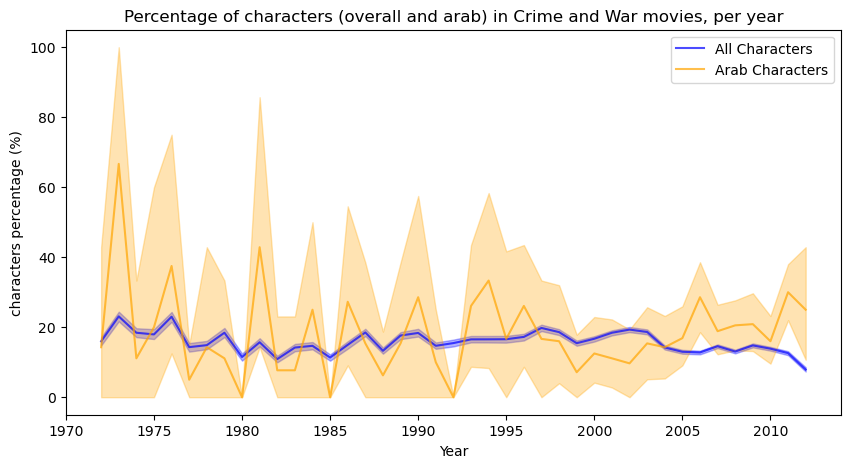

In [44]:
# plot the yearly trend of characters with roles in crime and war movies, all characters and arab characters
# fig, ax = plt.subplots()
# cri_and_vio.plot(x='release_date',y='mean',kind='bar',color='green' , ax=ax, alpha=0.7)
# cri_and_vio_ar.plot(x='release_date',y='mean',kind='bar',color='orange', secondary_y=True, ax=ax, alpha=0.7)
# ax2 = ax.twiny()

plt.figure(figsize=(10,5))
plt.fill_between(conf_int_mc['release_date'], conf_int_mc['low']*100, conf_int_mc['up']*100, alpha=0.3, color='b')
plt.plot(cri_and_vio['release_date'],cri_and_vio['mean']*100, label='All Characters', alpha=0.7, color='b')

plt.fill_between(conf_int_mc['release_date'], conf_int_mc['low_ar']*100, conf_int_mc['up_ar']*100, alpha=0.3, color='orange')
plt.plot(cri_and_vio_ar['release_date'],cri_and_vio_ar['mean']*100, label='Arab Characters', alpha=0.7, color='orange')

plt.legend()
plt.xlabel('Year')
plt.ylabel('characters percentage (%)')
plt.title('Percentage of characters (overall and arab) in Crime and War movies, per year')
plt.show()

In [45]:
# #modelling the data with a logistic regression model
# movies_characters_ar['year'] = movies_characters_ar['release_date'].dt.year
# model = smf.logit(formula='cri_and_vio_genres ~ year', data=movies_characters_ar)
# result = model.fit()
# print(result.summary())



In [46]:
# # Plot the logistic regression model and the data
# plt.figure(figsize=(10,5))
# plt.scatter(movies_characters_ar['year'], movies_characters_ar['cri_and_vio_genres'])
# plt.plot(movies_characters_ar['year'], result.predict(), color='red')
# plt.xlabel('Year')
# plt.ylabel('Probability of being a crime and war movie')
# plt.title('Probability of being a crime and war movie per year')

- Considering all the characters (blue bars), We can see that there is no clear trend. After 2003 the value seems eventually to decrease, that means a decresing partecipation for characters in W&C movies.

- Arabs (red bars) show a lot of fluctuations during the years, evidently during the last century. This is due to the small partecipation in W&C (less than 5 per year before 2003), generating less reliable percentages. After 2004 arab characters seems to play a higher fraction of these genre films than the overall characters in terms of mean values. Still the uncertainty given by bootstrapping shows that this can be stated only for years 2006, 2011 and 2012, where the confidence intervals do not intersect.

We can be more precise on this analysis looking at the feature before and after 2001. This grouping is done to avoid the problem of sparsity of data for arabs, specially doring the last century movies, that leads to high uncertainty. We will use an observational study scheme, with the treatment as the pubblication after 2001 and the outcome as the fraction of arab characters in W&C movies. First of all, we want to if the all characters trend is really negative for war and crime movies, confirming that this is not the reason for the possible positive correlalation for arabs.

In [47]:
# OVERALL TREND, all characters
# Create a new column for the treatment (after 2001)
movies_characters.loc[:, 'treatment'] = movies_characters['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters[movies_characters['treatment']==1]
control = movies_characters[movies_characters['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))

the treated population is 151159.
the control population is 156244.
The mean before 2001 is 0.166 with a standard deviation of 0.372.
The mean after 2001 is 0.142 with a standard deviation of 0.349.


In [48]:
# set the logistic regression model
model_1 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     335.5
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           6.73e-75
Time:                        00:05:06   Log-Likelihood:            -1.2260e+05
No. Observations:              307403   AIC:                         2.452e+05
Df Residuals:                  307401   BIC:                         2.452e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1655      0.00

From the linear regression model we see a slightly negative correlation betweeen the partecipation in war and crime films and the year of pubblication, confirming the qualitative obsevation on the yearly trend. Perticularly, there is negative correlation between producing the film after 2001 and characters in war and crime genre films. Is it the same for arabs?

In [49]:
# ARAB CHARACTERS TREND
# Create a new column for the treatment (after 2001)
movies_characters_ar.loc[:, 'treatment'] = movies_characters_ar['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters_ar[movies_characters_ar['treatment']==1]
control = movies_characters_ar[movies_characters_ar['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))


the treated population is 835.
the control population is 451.
The mean before 2001 is 0.151 with a standard deviation of 0.358.
The mean after 2001 is 0.202 with a standard deviation of 0.402.


In [50]:
# set the logistic regression model
model_2 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_ar)
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.203
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0227
Time:                        00:05:06   Log-Likelihood:                -603.71
No. Observations:                1286   AIC:                             1211.
Df Residuals:                    1284   BIC:                             1222.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1508      0.01

Differently from the general analysis, the arab characters show higher partecipation in violent films after 2001, from 15.1% to 20.2%. The logistic regression confirms this result with a positive coefficient for the treatment variable of 5.16%, the percentage increase, and a p-value= 2.3% < 5%, meaning that the result is significative.
We can therefore state that whereas the W&C characters fraction decrase in time, this is not the same for arabs, for which this percentage increases.
Now, we want to analyse this correlation to understand if there is a causal link between the treatment and the outcome, through an observational study.


## FIRST OBSERVATIONAL STUDY

As mentioned, we are investigating, for arab characters, the causal link between 'partecipation of a film released after 2001' and 'movie belongs to a c&w genre'. 
First of all, we need to discuss the possible confounders of the causal analysis. We treat the following features
- geographical zone of the movie pubblication
    - effect on the treatment: cinema industy can be more or less active in a country depending on cultural and economic effect that may change during the years. Es: boom of the indian industry after 2000
    - effect on the outcome: different countries have different cultures, so different incidence on a certain genre. es: a c&w film with arab caracters could be pubblished more probably in the US
- sex of the actor: 
    - effect on the treatment: arab females could be obstacled to be actress for religious rules that were stricter in the past, so there could be less female arab characters in the past 
    - effect on the outcome: male characters could be used more frequently in w&c films
- age of the actor at release 
    - effect on the treatment: during the film history it is possible that the presence of young actors was obtacled by certain legal/cultural rules
    - effect on the outcome: young characters and therefore actors could have a role more frequently in w&c films


In [51]:
# create one hot column for each gender
pd.get_dummies(movies_characters_ar['gender'])

dummies=pd.get_dummies(movies_characters_ar['gender']).astype(int).add_suffix('_onehot')
movies_characters_ar= pd.concat([movies_characters_ar, dummies] , axis=1)

In [52]:
# Get dummies for the countries
pd.get_dummies(movies_characters_ar['countries'].explode()).astype(int).groupby(level=0).sum().shape


(1286, 68)

There are 70 countries, so 70 onehot columns for this confounder. It could be better to group the country by the world regions according to the United Nations (https://ourworldindata.org/world-region-map-definitions). These depicts precise zones where the cultural influence is the same.


In [53]:
# Add the world region database, by the World Bank, to classify the countries
#country_regions = pd.read_csv(folder_add + '/world-regions-sdg-united-nations.csv',sep=',')
country_regions = pd.read_csv('Added_df/world-regions-sdg-united-nations.csv', sep=',')

columns=['Country', 'Code', 'Year', 'Region']
country_regions.columns=columns
# add list of countries that are not in the world bank dataset
# we add the United States of America that were present only as United States.
country_regions.loc[country_regions.shape[0]]=['United States of America','USA',2020,'Europe and Northern America']

# also, we notice that the country 'Djibouti' is the only country classified as 'Middle East and North Africa' so we change it to 'Northern Africa and Western Asia
country_regions.loc[country_regions['Country']=='Djibouti','Region']='Northern Africa and Western Asia'

country_regions.head()



,Country,Code,Year,Region
0,Afghanistan,AFG,2021,Central and Southern Asia
1,Aland Islands,ALA,2021,Europe and Northern America
2,Albania,ALB,2021,Europe and Northern America
3,Algeria,DZA,2021,Northern Africa and Western Asia
4,American Samoa,ASM,2021,Oceania


In [54]:
# Function to classify the countries in the world bank dataset
def continent(country_list):
    continent = set()
    missing_country = set()
    for country in country_list:
        if country in country_regions['Country'].values:
            continent.add(country_regions[country_regions['Country']==country]['Region'].values[0])
        else:
            continent.add('Other')
            missing_country.add(country)
    return (list(continent), list(missing_country))
continent(['gig'])[0]

                       


['Other']

In [55]:
country_regions['Region'].unique()

array(['Central and Southern Asia', 'Europe and Northern America',
       'Northern Africa and Western Asia', 'Oceania',
       'Sub-Saharan Africa', 'Latin America and Caribbean',
       'Eastern and South-Eastern Asia'], dtype=object)

Some countries are not present in the database because they are not still existing, are not politically recognised ore there is a spelling problem. We add them manually.

In [56]:
# Create the continent column
missing_country = set()
movies_characters_ar['continent'] = movies_characters_ar['countries'].apply(lambda x: continent(x)[0])
missing_country = movies_characters_ar['countries'].apply(lambda x: continent(x)[1])
missing_country = [item for sublist in missing_country for item in sublist]
missing_country = set(missing_country)
print(missing_country)



{'Taiwan', 'Soviet Union', 'Republic of Macedonia', 'Slovak Republic', 'England', 'Palestinian territories', 'Kingdom of Great Britain', 'West Germany', 'Mandatory Palestine', 'Malayalam Language', 'Czech Republic'}


In [57]:
# Add the missing countries to the world bank dataset 
missingcountry_dict = {'Country': ['Soviet Union',                'Republic of Macedonia',       'West Germany',                'Czech Republic',              'Malayalam Language',        'Slovak Republic',             'Kingdom of Great Britain',    'Mandatory Palestine',              'Taiwan',                         'England',                     'Palestinian territories'],
                        'Code': ['NaN']* 11, 
                        'Year': [2020]* 11, 
                        'Region': ['Europe and Northern America', 'Europe and Northern America', 'Europe and Northern America', 'Europe and Northern America', 'Central and Southern Asia', 'Europe and Northern America', 'Europe and Northern America', 'Northern Africa and Western Asia', 'Eastern and South-Eastern Asia', 'Europe and Northern America', 'Northern Africa and Western Asia']}
missingcountry_df = pd.DataFrame(missingcountry_dict)
country_regions = pd.concat([country_regions, missingcountry_df], axis=0)

# Recreate the continent column
movies_characters_ar['continent'] = movies_characters_ar['countries'].apply(lambda x: continent(x)[0])

In [58]:
# Get dummies for the countries
dummies2=pd.get_dummies(movies_characters_ar['continent'].explode()).astype(int).groupby(level=0).sum().add_suffix('_onehot')
dummies2.columns = dummies2.columns.str.replace(' ', '_')
dummies2.columns = dummies2.columns.str.replace('-', '_')
dummies2.head()

,Central_and_Southern_Asia_onehot,Eastern_and_South_Eastern_Asia_onehot,Europe_and_Northern_America_onehot,Latin_America_and_Caribbean_onehot,Northern_Africa_and_Western_Asia_onehot,Oceania_onehot,Sub_Saharan_Africa_onehot
202,1,0,0,0,0,0,0
564,1,0,0,0,0,0,0
798,1,0,0,0,0,0,0
1459,0,0,0,0,1,0,0
1460,0,0,0,0,1,0,0


In [59]:
# Add the world region dummies to the dataframe
movies_characters_ar= pd.concat([movies_characters_ar, dummies2] , axis=1)

Plot the confounders for the treatment and control groups

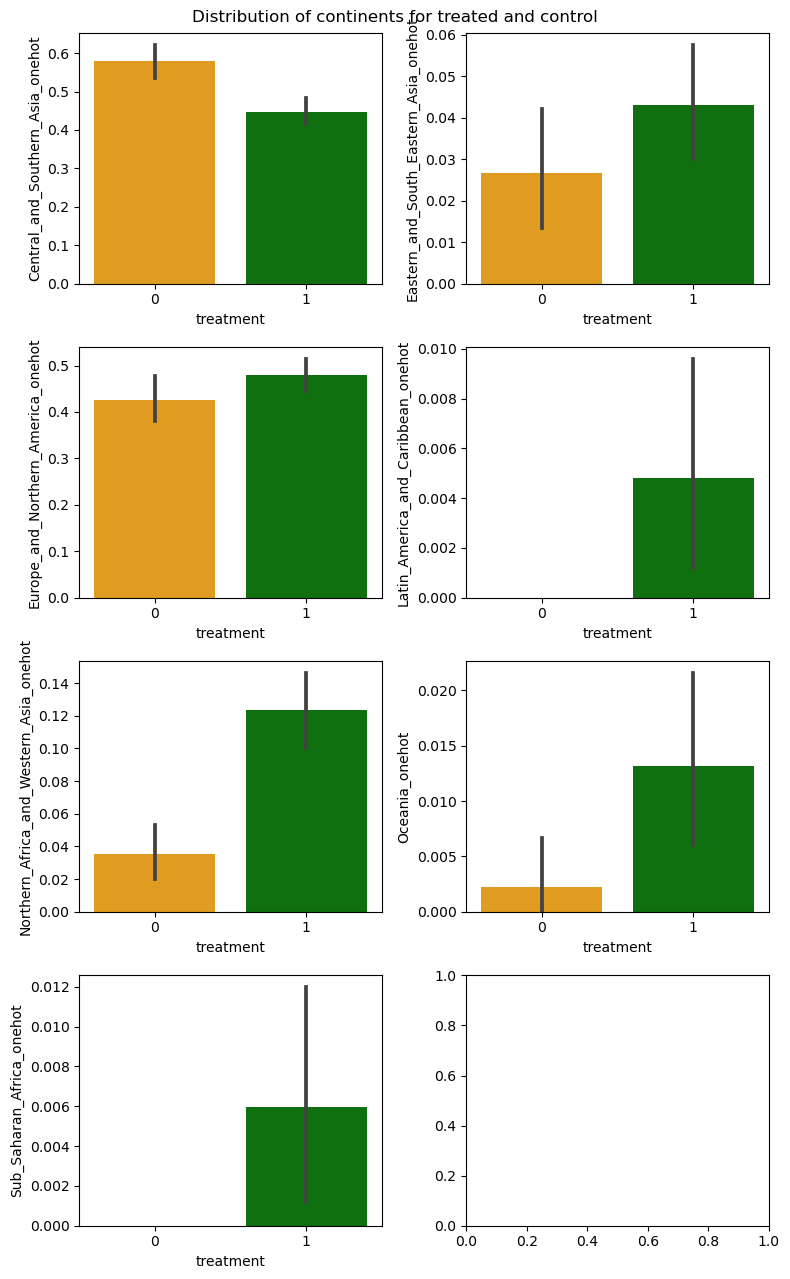

In [60]:
# plot continent distribution for treated and control with subplots for each continent
fig, ax = plt.subplots(4, 2, figsize=(8, 13))
fig.suptitle('Distribution of continents for treated and control')
for i, continent in enumerate(dummies2.columns):
    sns.barplot(x='treatment', y=continent, data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'], ax=ax[i//2, i%2])
plt.tight_layout()
plt.show()

For the propensity score, we are not going to use the 'Sub Saharan Africa' and 'Latin America and Carribean'. They appear only in the treatment feature and also rarely, less than 0.6% in mean. It means that their presence in the treatment should not change significntly the results.

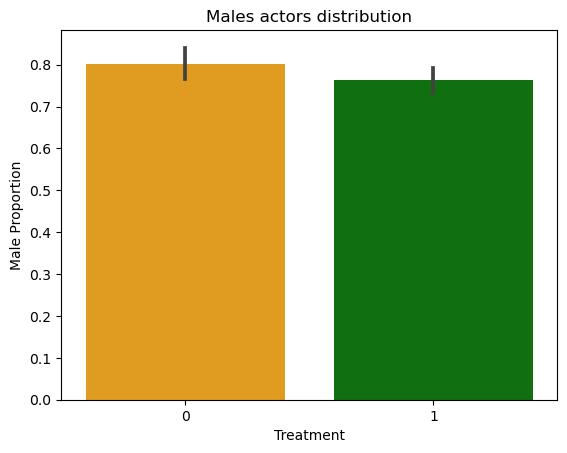

In [61]:
# plot gender distribution for treated and control population
sns.barplot(x='treatment', y='M_onehot', data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Males actors distribution')
plt.xlabel('Treatment')
plt.ylabel('Male Proportion')
plt.show()

Text(0, 0.5, 'Age')

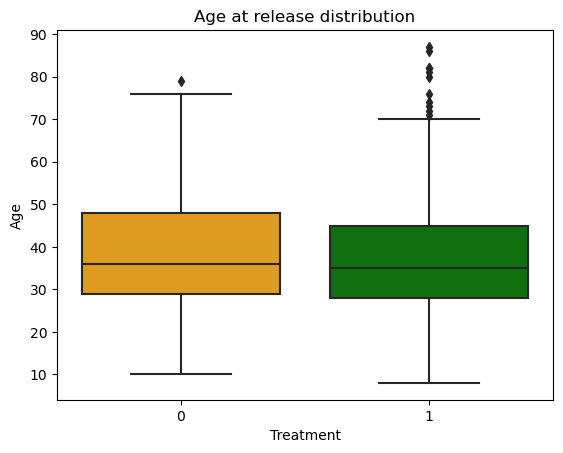

In [62]:
# Plot for age distribution for treated and control population
sns.boxplot(x='treatment', y='age_at_release', data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Age at release distribution')
plt.xlabel('Treatment')
plt.ylabel('Age')

Now, we create a propensity score to balance these two confounders in treatment and control group. We also standardise for the continuous variable.

In [63]:
# generate the one hot names string to be used in the model
dummies_list = ['C(' + x + ')' for x in list(dummies2.columns)]
dummies_string = ' + '.join(list(dummies_list))
dummies_string

'C(Central_and_Southern_Asia_onehot) + C(Eastern_and_South_Eastern_Asia_onehot) + C(Europe_and_Northern_America_onehot) + C(Latin_America_and_Caribbean_onehot) + C(Northern_Africa_and_Western_Asia_onehot) + C(Oceania_onehot) + C(Sub_Saharan_Africa_onehot)'

In [64]:
# standardise the age
movies_characters_ar['age_at_release'] = (movies_characters_ar['age_at_release'] - movies_characters_ar['age_at_release'].mean())/movies_characters_ar['age_at_release'].std()

mod = smf.logit(formula= 'treatment ~   age_at_release + C(M_onehot) + C(Central_and_Southern_Asia_onehot) + C(Eastern_and_South_Eastern_Asia_onehot) + C(Europe_and_Northern_America_onehot) + C(Northern_Africa_and_Western_Asia_onehot) + C(Oceania_onehot)', 
                 data= movies_characters_ar,
                 maxiter=1000)
res = mod.fit()

movies_characters_ar['Propensity_score'] = res.predict(movies_characters_ar)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.662749
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  852
Model:                          Logit   Df Residuals:                      844
Method:                           MLE   Df Model:                            7
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                 0.01809
Time:                        00:05:08   Log-Likelihood:                -564.66
converged:                       True   LL-Null:                       -575.07
Covariance Type:            nonrobust   LLR p-value:                  0.004066
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

In [65]:
# Propensity score statistics
movies_characters_ar['Propensity_score'].describe()

count    852.000000
mean       0.595070
std        0.074184
min        0.430957
25%        0.550752
50%        0.583896
75%        0.600547
max        0.895828
Name: Propensity_score, dtype: float64

In [66]:
# Similarity function
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [67]:
control.shape[0]

451

In [68]:
# Separate the treatment and control groups
treated = movies_characters_ar[movies_characters_ar['treatment'] == 1]
control = movies_characters_ar[movies_characters_ar['treatment'] == 0]

# Create an empty graph
G=nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treated.iterrows():
    for control_id, control_row in control.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [69]:
# concatenate the tuple elements (couples) in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_ar= movies_characters_ar.loc[matched]

In [70]:
# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
treated_bal = balanced_ar[balanced_ar['treatment']==1]
control_bal = balanced_ar[balanced_ar['treatment']==0]

print('the treated population is {}.' .format(treated_bal.shape[0]))
print('the control population is {}.' .format(control_bal.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control_bal['cri_and_vio_genres'].mean(), 3), round(control_bal['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated_bal['cri_and_vio_genres'].mean(), 3), round(treated_bal['cri_and_vio_genres'].std(), 3)))

the treated population is 345.
the control population is 345.
The mean before 2001 is 0.145 with a standard deviation of 0.353.
The mean after 2001 is 0.206 with a standard deviation of 0.405.


With the balanced treated and control groups, we can repeat the linear regression to check if there is still a significative correlation.

In [71]:
# set the logistic regression model
model_3 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=balanced_ar)
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.435
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0356
Time:                        00:06:45   Log-Likelihood:                -309.72
No. Observations:                 690   AIC:                             623.4
Df Residuals:                     688   BIC:                             632.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1449      0.02

After the balancing of the treated and control samples for the confounding features the linear regression predics a higher probability difference between character before and after 2001 that had a part in w&c movies, from 5.16% to 6.38%. In addition, the result is significative (p-value = 2.8% < alpha).


# Westen countries

Now, we want to measure the effect on films on movies pubblished on western countries only. With this filtering we hypotise a stronger dependence of the outcome on the treatment, since 9/11 had a higher cultural impact on western countries. still, there is the problem of a smaller sample thats risks to make the analysis less significative. We repeat the exact procedure with the initial evaluation and the observational study. The confounder are the same, beside of the geographical region that is considered as the same, culturally.

In [72]:
# define the matrix only for western countries
movies_characters_western = movies_characters[movies_characters['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
movies_characters_ar_western = movies_characters_ar[movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
movies_characters_western.columns

Index(['wikiID', 'freeID', 'movie_name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'character_name', 'birth', 'gender',
       'height', 'ethnicity_code', 'actor_name', 'age_at_release',
       'freeID_character_actor_map', 'freeID_character', 'freeID_actor',
       'no_genres', 'cri_and_vio_genres', 'treatment'],
      dtype='object')

In [73]:
# do the yearly plot for the western filtered
# movies_characters_western= movies_characters[movies_characters['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
cri_and_vio_western= movies_characters_western.groupby(movies_characters_western['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_western['mean'] = movies_characters_western.groupby(movies_characters_western['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']
cri_and_vio_ar_western= movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_ar_western['mean'] = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']

Following the same steps, we consider the yearly trends for w&c movies characters, analysing the percentage of overall characters and arab characters palying them. This time we select for films in the western countries

In [74]:
conf_int_mc_w = pd.DataFrame(columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])
for year in range(limit_years[0],limit_years[1]):
    # We compute the confidence interval for the fraction of missing data for every year
    low, up = bootstrapping(1000, movies_characters_western[movies_characters_western['release_date'].dt.year==year]['cri_and_vio_genres'])
    low_ar, up_ar = bootstrapping(1000, movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year==year]['cri_and_vio_genres'])

    conf_int_mc_w = pd.concat([conf_int_mc_w, pd.DataFrame([[int(year), low, up, low_ar, up_ar]], columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])], ignore_index=True) 
    # We print the year, the fraction of missing data and the confidence interval
    # print('Year: {}, confidence interval: [{:.3}%, {:.3}%]'.format(year, low*100, up*100))

In [75]:

conf_int_mc_w['release_date'] = conf_int_mc_w['release_date'].astype(int)

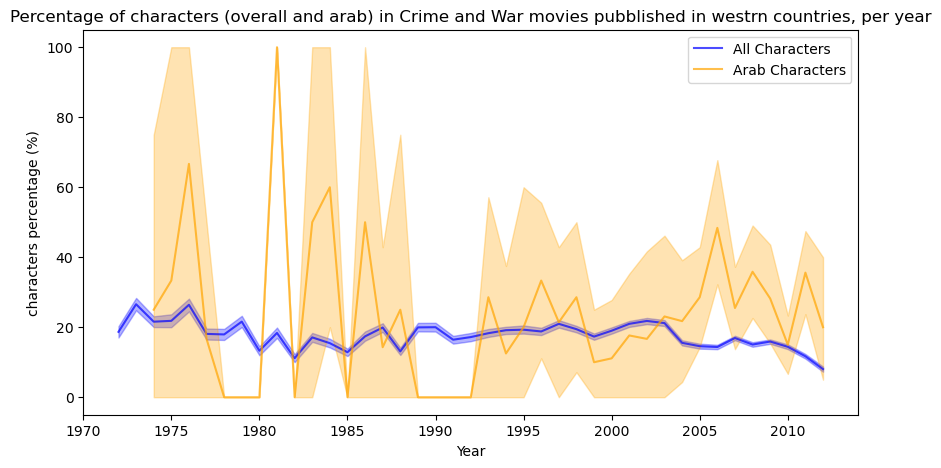

In [76]:
# plot the yearly trend of characters with roles in crime and war movies, all characters and arab characters
# fig, ax = plt.subplots()
# cri_and_vio.plot(x='release_date',y='mean',kind='bar',color='green' , ax=ax, alpha=0.7)
# cri_and_vio_ar.plot(x='release_date',y='mean',kind='bar',color='orange', secondary_y=True, ax=ax, alpha=0.7)
# ax2 = ax.twiny()

plt.figure(figsize=(10,5))
plt.fill_between(conf_int_mc_w['release_date'], conf_int_mc_w['low']*100, conf_int_mc_w['up']*100, alpha=0.3, color='b')
plt.plot(cri_and_vio_western['release_date'],cri_and_vio_western['mean']*100, label='All Characters', alpha=0.7, color='b')

plt.fill_between(conf_int_mc_w['release_date'], conf_int_mc_w['low_ar']*100, conf_int_mc_w['up_ar']*100, alpha=0.3, color='orange')
plt.plot(cri_and_vio_ar_western['release_date'],cri_and_vio_ar_western['mean']*100, label='Arab Characters', alpha=0.7, color='orange')

plt.legend()
plt.xlabel('Year')
plt.ylabel('characters percentage (%)')
plt.title('Percentage of characters (overall and arab) in Crime and War movies pubblished in westrn countries, per year')
plt.show()

The plot on the yearly evolution on character percentage is really similar respect to the all word case. For arabs we definitely see strong fluctuations before 1993 for the lack of data points. As previously, this problem is faced taking two temporary bloks, one before and one after 9/11.

In [77]:
# # For every arab character, we indicate if they play a movie of the Crime, War Genre or not
# Selected_genres = ['Crime Fiction' , 'War film']  
# movies_characters_ar_western.loc[:, 'cri_and_vio_genres'] = movies_characters_ar_western['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).astype(int)
# movies_characters_ar_western.head(2)

In [78]:
# Consider all the characters in the western countries
# set the logistic regression model
model_4 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_western)
result_4 = model_4.fit()
print(result_4.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     357.8
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           9.64e-80
Time:                        00:06:52   Log-Likelihood:            -1.0070e+05
No. Observations:              227292   AIC:                         2.014e+05
Df Residuals:                  227290   BIC:                         2.014e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1862      0.00

In [79]:
# Create a new column for the treatment (after 2001)
movies_characters_ar_western.loc[:, 'treatment'] = movies_characters_ar_western['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters_ar_western[movies_characters_ar_western['treatment']==1]
control = movies_characters_ar_western[movies_characters_ar_western['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))


the treated population is 396.
the control population is 181.
The mean before 2001 is 0.204 with a standard deviation of 0.404.
The mean after 2001 is 0.283 with a standard deviation of 0.451.


In [80]:
# Consider only the arab characters in the western countries
# set the logistic regression model
model_5 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_ar_western)
result_5 = model_5.fit()
print(result_5.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.001
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0459
Time:                        00:06:52   Log-Likelihood:                -339.95
No. Observations:                 577   AIC:                             683.9
Df Residuals:                     575   BIC:                             692.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2044      0.03

Similar results for the initial values, whereas the analysis on all the character is significant but the coefficient is negative, -0.0299, For the abas case we see a clear growth between control and treatmen group. The coefficient in fact is 0.0784, meaning a mean increase of 7,84%, with a p-value that is lower than 5% and therefore significative. 


## SECOND OBSEREVATIONAL STUDY

Firstly we analyse the confounders on treated and control groups, then we balance using the propensity score.

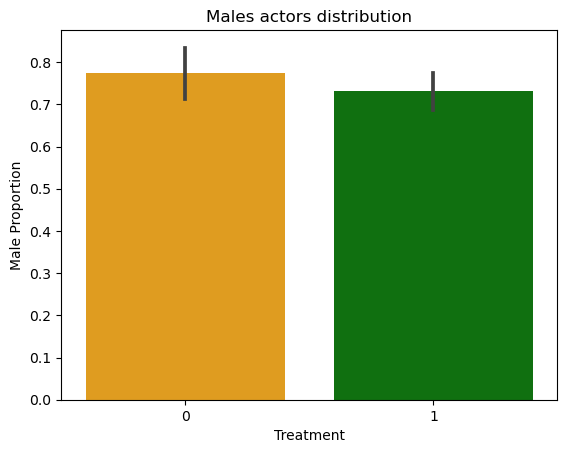

In [81]:
# plot gender distributions for treated and control population
sns.barplot(x='treatment', y='M_onehot', data=movies_characters_ar_western[movies_characters_ar_western['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Males actors distribution')
plt.xlabel('Treatment')
plt.ylabel('Male Proportion')
plt.show()

Text(0, 0.5, 'Age')

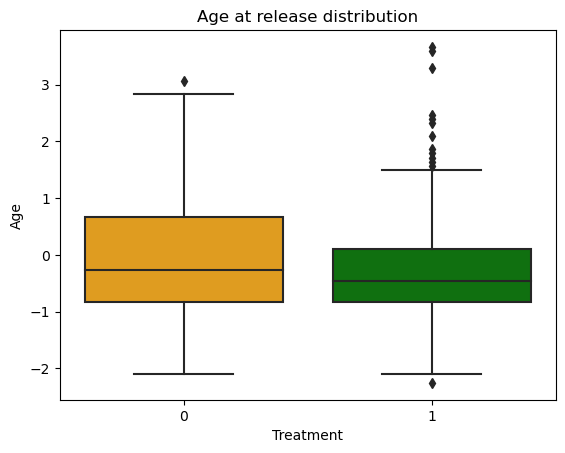

In [82]:
# Plot for age distribution for treated and control population
sns.boxplot(x='treatment', y='age_at_release', data=movies_characters_ar_western[movies_characters_ar_western['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Age at release distribution')
plt.xlabel('Treatment')
plt.ylabel('Age')

In [83]:
# standardise the age
movies_characters_ar_western['age_at_release'] = (movies_characters_ar_western['age_at_release'] - movies_characters_ar_western['age_at_release'].mean())/movies_characters_ar_western['age_at_release'].std()

# set the logistic regression model for propensity score
mod = smf.logit(formula= 'treatment ~   age_at_release + C(M_onehot)',
                 data=movies_characters_ar_western)
res = mod.fit()

movies_characters_ar_western['Propensity_score'] = res.predict(movies_characters_ar_western)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.658279
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  367
Model:                          Logit   Df Residuals:                      364
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                0.009779
Time:                        00:06:52   Log-Likelihood:                -241.59
converged:                       True   LL-Null:                       -243.97
Covariance Type:            nonrobust   LLR p-value:                   0.09202
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3817      0.245      1.557      0.119      -0.099       0.862
C(M_onehot)

In [84]:
# Propensity score statistics
movies_characters_ar_western['Propensity_score'].describe()

count    367.000000
mean       0.618529
std        0.055693
min        0.399301
25%        0.589761
50%        0.630463
75%        0.652955
max        0.732778
Name: Propensity_score, dtype: float64

In [85]:
# Similarity function
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [86]:
control.shape[0]

181

In [87]:
# Separate the treatment and control groups
treated = movies_characters_ar_western[movies_characters_ar_western['treatment'] == 1]
control = movies_characters_ar_western[movies_characters_ar_western['treatment'] == 0]

# Create an empty graph
G=nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treated.iterrows():
    for control_id, control_row in control.iterrows():
        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],  treatment_row['Propensity_score'])
                           
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
    

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [88]:
# concatenate the tuple elements (couples) in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [89]:
# create the balanced dataset
balanced_ar_western = movies_characters_ar_western.loc[matched]

In [90]:
# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
treated_bal = balanced_ar_western[balanced_ar_western['treatment']==1]
control_bal = balanced_ar_western[balanced_ar_western['treatment']==0]

print('the treated population is {}.' .format(treated_bal.shape[0]))
print('the control population is {}.' .format(control_bal.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control_bal['cri_and_vio_genres'].mean(), 3), round(control_bal['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated_bal['cri_and_vio_genres'].mean(), 3), round(treated_bal['cri_and_vio_genres'].std(), 3)))

the treated population is 140.
the control population is 140.
The mean before 2001 is 0.214 with a standard deviation of 0.412.
The mean after 2001 is 0.336 with a standard deviation of 0.474.


In [91]:
# set the logistic regression model
model_6 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=balanced_ar_western)
result_6 = model_6.fit()
print(result_6.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.237
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0229
Time:                        00:06:59   Log-Likelihood:                -168.93
No. Observations:                 280   AIC:                             341.9
Df Residuals:                     278   BIC:                             349.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2143      0.03

Text(0, 0.5, 'Probability of being a crime and war movie')

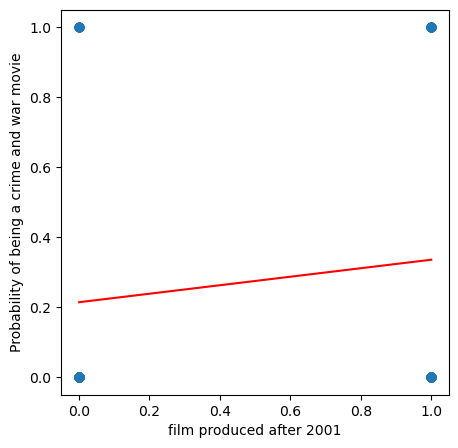

In [92]:
# plot the linear regression model and the data
plt.figure(figsize=(5,5))
plt.scatter(balanced_ar_western['treatment'], balanced_ar_western['cri_and_vio_genres'])
plt.plot(balanced_ar_western['treatment'], result_6.predict(), color='red')
plt.xlabel('film produced after 2001')
plt.ylabel('Probability of being a crime and war movie')

The model confirms a significant correleation between the treatment and the outcome, balancing the 2 groups with the propensity scores. Also, the increase before and after 2001 is 12,14% the largest seen in the analysis, from 21.43% to 33.57%.

The naive analysis confirms for both all world and western countries an increas of arab characters having parts in w&c movies after 2001. So, with a significance level of 5% we exclude the hypothesis of no correlation between treatment and control.

We now sum up the results of the linear regression models: intercept, coefficients, p-value and r-squared

In [93]:
# sum up the linear regression model
# generate a dataframe with the results of models 2, 3, 5, 6
summary = pd.DataFrame({'model': ['all countries, no balancing', 'all countries, balancing', 'western countries, no balancing', 'western countries, balancing'],
                        'R2': [result_2.rsquared, result_3.rsquared, result_5.rsquared, result_6.rsquared],
                        'p-value': [result_2.pvalues[1], result_3.pvalues[1], result_5.pvalues[1], result_6.pvalues[1]],
                        'intercept': [result_2.params[0], result_3.params[0], result_5.params[0], result_6.params[0]],
                        'coef': [result_2.params[1], result_3.params[1], result_5.params[1], result_6.params[1]]})
summary


,model,R2,p-value,intercept,coef
0,"all countries, no balancing",0.004036,0.022707,0.150776,0.051619
1,"all countries, balancing",0.006405,0.035565,0.144928,0.060870
2,"western countries, no balancing",0.006910,0.045948,0.204420,0.078408
3,"western countries, balancing",0.018489,0.022865,0.214286,0.121429


# Adding IMDb ratings and relevancy measure
We import the IMDb dataset to populate the our data with user ratings

In [94]:
# IMPORTING IMDb DATASET
imdb_data_ratings = pd.read_csv(folder_std + "/imdb_ratings.tsv",sep='\t')
imdb_data_titles = pd.read_csv(folder_std + "/imdb_titles.tsv",sep='\t')
imdb_data = pd.merge(imdb_data_ratings,imdb_data_titles,on=['tconst'])

imdb_data = imdb_data.rename(columns={'primaryTitle': 'movie_name'})

imdb_data = imdb_data[['movie_name','averageRating']]
# imdb_data.head()

In [95]:
# removing duplicate movie entries 
# by compressing them into 1 entry which is the mean
imdb_data_mean = imdb_data.groupby(['movie_name']).mean().reset_index().drop_duplicates()

In [96]:
# making all titles lower-case to make merging more effective
imdb_data_mean['movie_name'] = imdb_data_mean['movie_name'].str.lower()
movies_characters_ar['movie_name'] = movies_characters_ar['movie_name'].str.lower()

# merging
movies_characters_ar_ratings = pd.merge(movies_characters_ar,imdb_data_mean,on=['movie_name'],how='left')

In [97]:
# removing rows with NaN revenue data
filtered_movies_characters_ar_ratings = movies_characters_ar_ratings[movies_characters_ar_ratings['revenue'].notna() & movies_characters_ar_ratings['averageRating'].notna()]
filtered_movies_characters_ar_ratings.shape
# creating a year column
filtered_movies_characters_ar_ratings['release_year'] = filtered_movies_characters_ar_ratings['release_date'].dt.year

We compute the following indicator for each movie as a weighted sum of rating and revenue data: 
$$\textrm{coeff} = C1\cdot \overline{\textrm{revenue}} + C2\cdot \overline{\textrm{rating}}$$

Where the $\overline{\textrm{bar}}$ means the value is normalized with the movie's release year's mean and standard deviation.

In [98]:
# Calculate the new column "relevance_coeff" (standardization by year)

weighting = [0.5, 0.5] # equal weights
filtered_movies_characters_ar_ratings['relevance_coeff'] = weighting[0] * ((filtered_movies_characters_ar_ratings['revenue'] - filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('mean')) 
/ filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('std')) + \
                        weighting[1]  * ((filtered_movies_characters_ar_ratings['averageRating'] - filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('mean')) 
                                         / filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('std'))

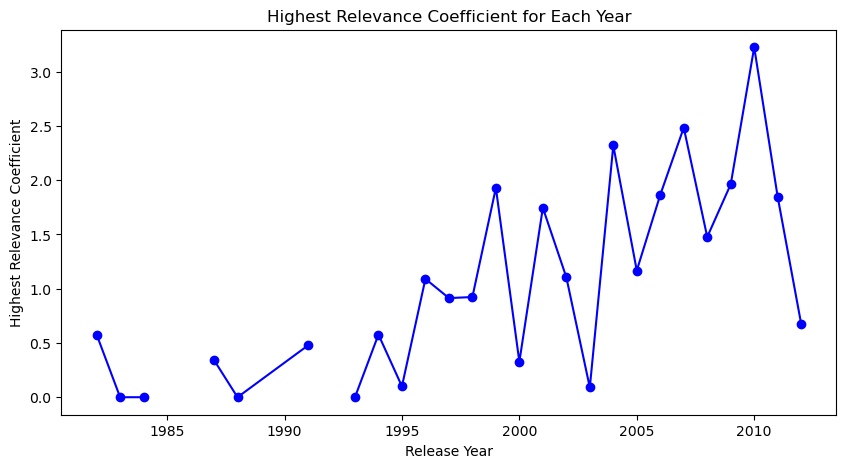

In [141]:
plt.figure(figsize=(10,5))
max_relevance_per_year_ar = filtered_movies_characters_ar_ratings.groupby('release_year')['relevance_coeff'].max()

# Plot the results
plt.plot(max_relevance_per_year_ar.index, max_relevance_per_year_ar.values, marker='o', linestyle='-', color='b')
plt.xlabel('Release Year')
plt.ylabel('Highest Relevance Coefficient')
plt.title('Highest Relevance Coefficient for Each Year')
plt.show()

# Plot text analysis through NLP

It is important to verify that the characters we are considering are present in the plot. In fact, only these characters can be used for a sentiment analysis in the further stages of the project.

We want to import the plot summaries and add them to the current Dataframe, containing arab characters.

In [100]:
# import the plot summaries
plot_summaries = pd.read_csv(folder_std + "/plot_summaries.txt",sep='\t',names=['wikiID','summary'])
plot_summaries.head()

,wikiID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [101]:
# checking for NaN values
plot_summaries.isna().sum()

wikiID     0
summary    0
dtype: int64

In [102]:
#checking the length distribution for the movie plots
plot_summaries['length_plot'] = plot_summaries['summary'].apply(lambda x: len(x))
plot_summaries

,wikiID,summary,length_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178
1,31186339,The nation of Panem consists of a wealthy Capi...,4559
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",220
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289


In [103]:
plot_summaries['length_plot'].describe()

count    42303.000000
mean      1784.034229
std       1808.925536
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: length_plot, dtype: float64

We can see from the describe function that the distribution of movie plots is very spread as the mean as big as the standard deviation. In addition, we have a movie plot with 28159 characters which may suggest that there are outliers, since the upper quartile is much smaller than the maximum. We decide to look at it more closely using a box plot.

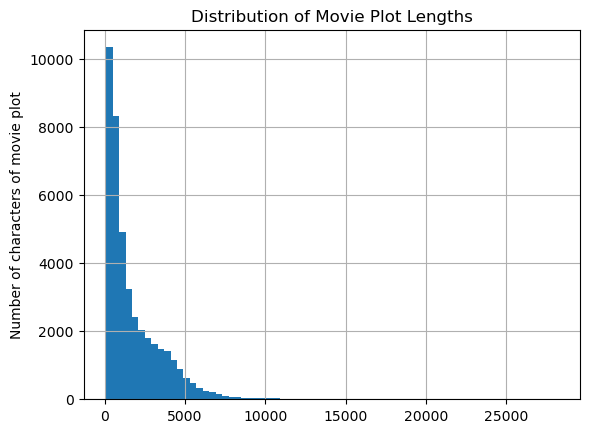

In [104]:
plot_summaries.hist(column=['length_plot'],bins=70)
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')
# Show the plot
plt.show()

Our intuition was right. We can see from the histogram that the distribution of length of the movie plots is heavy tailed. Consequently, we decide to show the distribution with a boxplot employing a logarithmic scale for the y-axis, to make the visualization more interpretable.

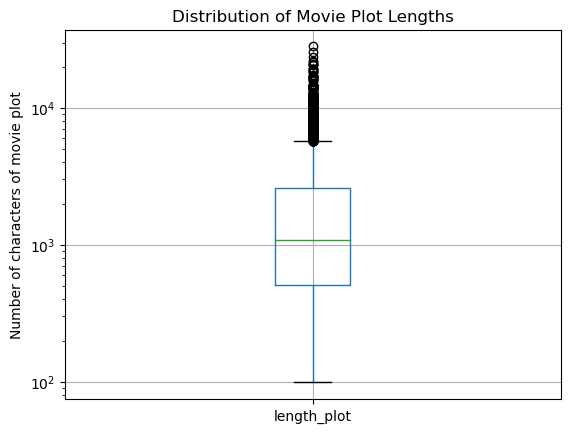

In [105]:
plot_summaries.boxplot(column=['length_plot'])
plt.yscale('log')
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')

# Show the plot
plt.show()

## Sentiment Analysis

Mohammad's part :

## Named entity recognition

In [134]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import numpy as np

# Filter for Western films and split by release date
western_movies = movies[movies['genres'].apply(lambda x: 'Western' in x)]
western_pre_2001 = western_movies[pd.to_datetime(western_movies['release_date']).dt.year < 2001]
western_post_2001 = western_movies[pd.to_datetime(western_movies['release_date']).dt.year >= 2001]

# Load the tokenizer and BERT model for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Initialize sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to analyze the sentiment of a summary
def analyze_sentiment(summary):
    return sentiment_pipeline(summary[:512])[0]  # BERT handles up to 512 tokens

# Apply sentiment analysis to summaries of Western films before 2001
western_pre_2001_summaries = plot_summaries[plot_summaries['wikiID'].isin(western_pre_2001['wikiID'])]
western_pre_2001_summaries['sentiment'] = western_pre_2001_summaries['summary'].apply(analyze_sentiment)

# Apply sentiment analysis to summaries of Western films after 2001
western_post_2001_summaries = plot_summaries[plot_summaries['wikiID'].isin(western_post_2001['wikiID'])]
western_post_2001_summaries['sentiment'] = western_post_2001_summaries['summary'].apply(analyze_sentiment)

# We now have two DataFrames 'western_pre_2001_summaries' and 'western_post_2001_summaries'
# with analyzed sentiments for each period.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


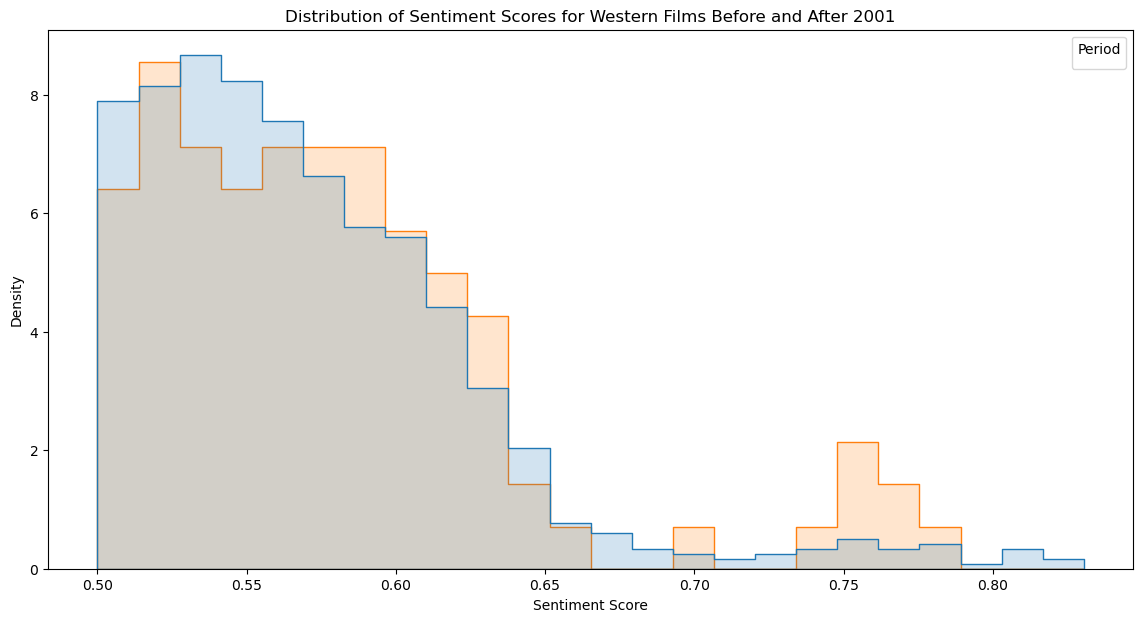

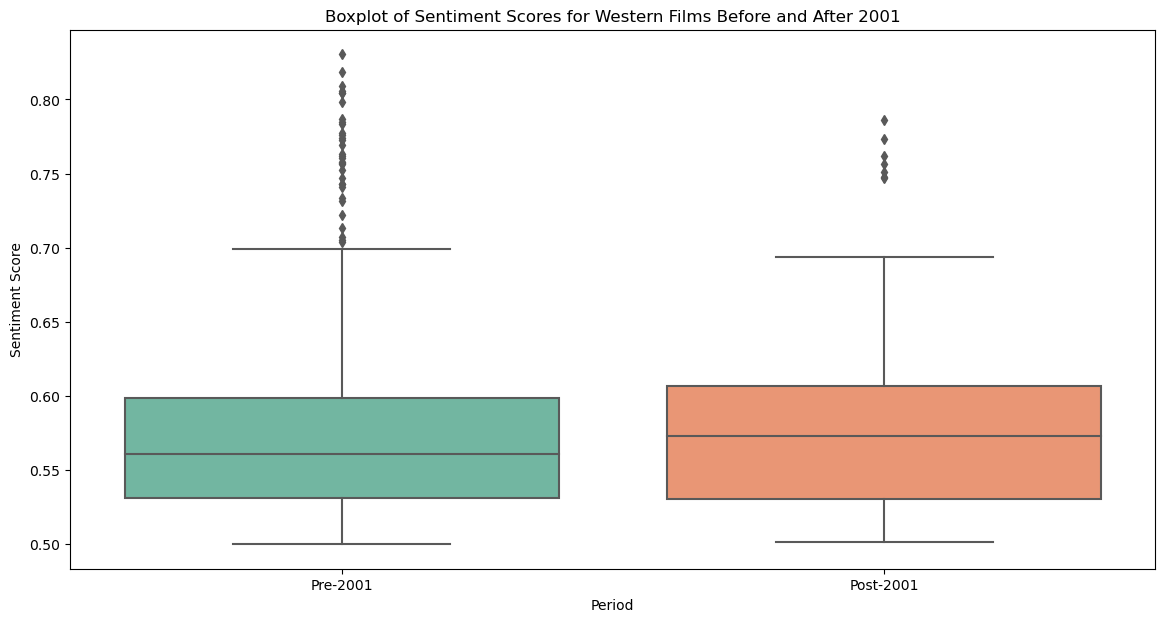

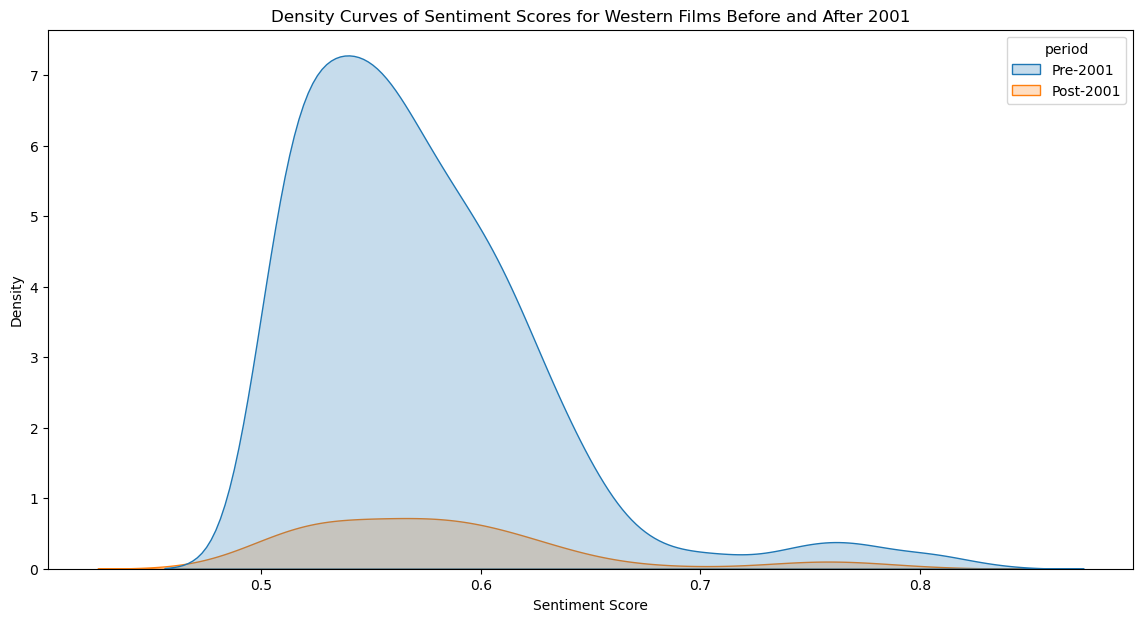

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the sentiment score is numeric and not a dictionary
# If the sentiment score is stored in a dictionary with a 'score' key, we extract it as follows:
western_pre_2001_summaries['sentiment_score'] = western_pre_2001_summaries['sentiment'].apply(lambda x: x['score'])
western_post_2001_summaries['sentiment_score'] = western_post_2001_summaries['sentiment'].apply(lambda x: x['score'])

# Combine the two DataFrames for visualization
combined_data = pd.concat([
    western_pre_2001_summaries.assign(period="Pre-2001"),
    western_post_2001_summaries.assign(period="Post-2001")
])

# Improved histograms with distinct colors and transparencies
plt.figure(figsize=(14, 7))
sns.histplot(data=combined_data, x='sentiment_score', hue='period', element='step', stat='density', common_norm=False, alpha=0.2)
plt.title('Distribution of Sentiment Scores for Western Films Before and After 2001')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Period')
plt.show()

# Boxplots to show the distribution of sentiment scores
plt.figure(figsize=(14, 7))
sns.boxplot(data=combined_data, x='period', y='sentiment_score', palette="Set2")
plt.title('Boxplot of Sentiment Scores for Western Films Before and After 2001')
plt.xlabel('Period')
plt.ylabel('Sentiment Score')
plt.show()

# Density curves
plt.figure(figsize=(14, 7))
sns.kdeplot(data=combined_data, x='sentiment_score', hue='period', fill=True)
plt.title('Density Curves of Sentiment Scores for Western Films Before and After 2001')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()


In [148]:
print(combined_data.columns)



Index(['wikiID', 'summary', 'length_plot', 'named_entities', 'sentiment',
       'sentiment_score', 'period', 'sentiment_category'],
      dtype='object')


We need to a partial preprocessing of the summaries before feeding the text to the spacy model to perform named entity recognition. For example, for movie number 4075 in the movie plots dataset, the plot begins with "{{Further2}}", which maybe recognized as an entity. We only do a partial preprocessing to remove alpha numeric characters and some punctuation. We will not make the text to lower case since the model uses the cases information and the model processes the raw text and do some preprocessing internally (for example removal of stopwords).

In [107]:
def partial_preprocess_for_ner(text):
    words = text.split()
    punctuation=list(string.punctuation)
    p= [word for word in words if word.isalpha() and word not in punctuation]
    res = " ".join([word for word in p])
    return res

We employ the spaCy tool, utilizing the 'en_core_web_sm' model, to conduct a linguistic analysis of movie plots. spaCy, a language processing tool, possesses capabilities such as sentence breakdown, word tagging, and named entity recognition (NER). Specifically, we leverage its NER functionality to identify individuals in film summaries. Our interest lies in determining whether these individuals bear Arabic names. To achieve this, we cross-reference the identified names from spaCy with a dataset containing Arabic names.

In [108]:
model = spacy.load("en_core_web_sm") 
 
def extract_entities(text):
    doc = model(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

# Apply the function to the DataFrame and create a new column for named entities
plot_summaries['named_entities'] = plot_summaries['summary'].apply(partial_preprocess_for_ner)
plot_summaries['named_entities'] = plot_summaries['summary'].apply(extract_entities)
plot_summaries

# plot_summaries.to_csv("basic_preprocessed_ner.csv")

,wikiID,summary,length_plot,named_entities
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",220,"[(Reema, PERSON), (Muslim, NORP), (Malabar, GP..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971,"[(1928, DATE), (Hollywood, GPE), (Leo Andreyev..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871,"[(American, NORP), (Randy Parsons, ORG), (mid-..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289,"[(Abdur Rehman Khan, PERSON), (Afghanistan, GP..."


In [109]:
# We make a deep copy of the dataframe, before filtering in subsequent cells
plot_summaries_chars = plot_summaries.copy()

In [110]:
# Remove brackets in named_entities column
plot_summaries_chars['named_entities']= plot_summaries_chars['named_entities'].apply(lambda x: ast.literal_eval(str(x)))

In [111]:
#we do a set so that we only count each entity one time.
plot_summaries_chars["Chars in plot"] = plot_summaries_chars['named_entities'].apply(lambda x: 
   set( [ entity for entity in x if entity[1] == "PERSON"])
)
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Haymitch Abernathy, PERSON), (Peeta, PERSON)..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(DYSP Sankaranarayanan, PERSON), (Manapally M..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Moran, PERSON), (Henr..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael, PERSON), (Azaria, PERSON), (Michael..."


In [112]:
all_chars = [char for sublist in plot_summaries_chars['Chars in plot'] for char in sublist]
chars_counts = Counter(all_chars)
chars_counts.most_common(10)

[(('Jack', 'PERSON'), 608),
 (('John', 'PERSON'), 583),
 (('Tom', 'PERSON'), 571),
 (('Sam', 'PERSON'), 494),
 (('Mary', 'PERSON'), 482),
 (('Joe', 'PERSON'), 479),
 (('David', 'PERSON'), 462),
 (('Paul', 'PERSON'), 440),
 (('Michael', 'PERSON'), 420),
 (('Peter', 'PERSON'), 407)]

In [113]:
# Take only character names
char_names = [x[0] for x in all_chars]

In [114]:
#get the top 10 arabic names mentionned in the movie plots
res = []
for element,count in chars_counts.items():
    name = str(element[0]).lower()
    if(name in arab_names):
        res.append((name,count))
    
res = sorted(res, key=lambda pair: pair[1], reverse=True)
res[:10]

[('ali', 109),
 ('omar', 33),
 ('hassan', 28),
 ('malik', 28),
 ('salim', 27),
 ('abbas', 24),
 ('fatima', 23),
 ('rahman', 22),
 ('aman', 22),
 ('samir', 20)]

In [115]:
# Add a column to the dataframe that indicates if the movie plot contains an arabic name
plot_summaries_chars['has_arabic_character'] = plot_summaries_chars['Chars in plot'].apply(lambda x: any(str(entity[0]).lower() in arab_names for entity in x))

# New dataframe, filtering on movies with arabic characters
movies_with_arabic = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==True]
display(movies_with_arabic.head())
print(f'There are {movies_with_arabic.shape[0]} movies with arabic characters')

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Ari Ben Canaan, PERSON), (Ari Ben Canaan's, ...",True
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Sinclair, PERSON), (Kid, PERSON), (Zora, PER...",True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Semyon, PERSON), (Kirill, PERSON), (Anna Khi...",True
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Zafar, PERSON), (Tahaan, PERSON), (Zoya, PER...",True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Michael, PERSON), (Kahara, PERSON), (Jada, P...",True


There are 897 movies with arabic characters


### Pre-processing pipeline for wordcloud

We want to visualize the most recurrent words that appear in teh movie plots that mention an arabic character and compare it with the same visualization for movies that do not mention arabic characters. 

To do so, we need to pre-process plot summaries so that we can evaluate the most meaningful words in each plot. First, we remove punctuation and english stopwords (provided by nltk library). Secondly, we lemmatize. We chose lemmatization over stemming because it is more accurate and our dataset is not large, making the computational time acceptable.

In [116]:
wl=WordNetLemmatizer()
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)

stop.update(punctuation)



def preprocess_text(text):
    text = text.lower()
    words = text.split()
    p= [word for word in words if word.isalpha() and word not in stop]
    text= " ".join([wl.lemmatize(word) for word in p])
    
    
    return text

In [117]:
# Apply the preprocessing function to the summaries
movies_with_arabic.loc[:,1]= movies_with_arabic['summary'].apply(lambda x:preprocess_text(x))

movies_with_arabic.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,1
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Ari Ben Canaan, PERSON), (Ari Ben Canaan's, ...",True,film based event happened ship exodus well eve...
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Sinclair, PERSON), (Kid, PERSON), (Zora, PER...",True,following sudden death father local church don...
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Semyon, PERSON), (Kirill, PERSON), (Anna Khi...",True,anna khitrova midwife london find diary body g...
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Zafar, PERSON), (Tahaan, PERSON), (Zoya, PER...",True,tahaan life grandfather mother haba older sist...
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Michael, PERSON), (Kahara, PERSON), (Jada, P...",True,film begin boy named michael kid hots beautifu...


In [118]:
# Helper function to plot wordclouds
def make_WC_visualization(data,mask=None):
    text =  " ".join(data) 
    wc = WordCloud(background_color='white',colormap='copper',max_words=100,mask=mask, width = 800, height = 500).generate(text)
    plt.imshow(wc)
    plt.axis("off")

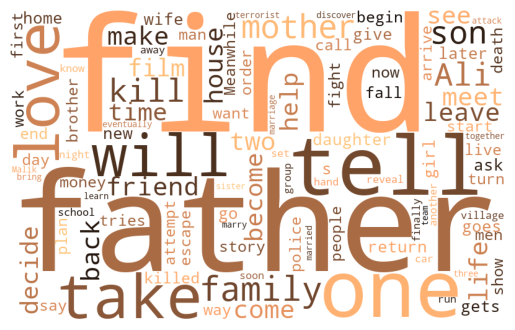

In [119]:
# Wordcloud visualization of the 100 most common words in the movie plots
make_WC_visualization(movies_with_arabic['summary'])

Now we want to show the wordcloud for movies without arab characters in the plot.

In [120]:
movies_with_nonarabs = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==False]
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Haymitch Abernathy, PERSON), (Peeta, PERSON)...",False
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(DYSP Sankaranarayanan, PERSON), (Manapally M...",False
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Moran, PERSON), (Henr...",False
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael, PERSON), (Azaria, PERSON), (Michael...",False


In [121]:
movies_with_nonarabs['summary'] = movies_with_nonarabs['summary'].apply(lambda x:preprocess_text(x))
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,taxi driver develop bizarre despite realize di...,178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,nation panem consists wealthy capitol twelve p...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Haymitch Abernathy, PERSON), (Peeta, PERSON)...",False
2,20663735,poovalli induchoodan sentenced six year prison...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(DYSP Sankaranarayanan, PERSON), (Manapally M...",False
3,2231378,lemon drop kid new york city illegally touting...,4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Moran, PERSON), (Henr...",False
4,595909,adventist church pastor michael wife two daugh...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael, PERSON), (Azaria, PERSON), (Michael...",False


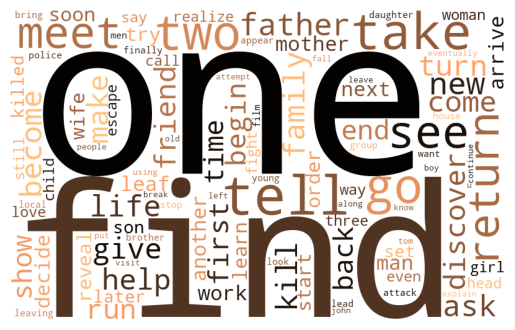

In [122]:
make_WC_visualization(movies_with_nonarabs['summary'])

We can see clearly from the wordcloud visualization that the lexical field differ: for the movies with arabic have much more words with bad conotation, like kill, drugs, help, and attack whereas for the movies in which the plot doesn't mention an arabic character, the most repeated words are more neutral and/or more positive for example family, life, son ,decide... Eventhough both negative words and positive words in both categories, it is worth noting that the scales for the words in common differ: for example the word kill, we can see that it is bigger in the movies with arabic characters. Eventhough, the number of films of each categories vary a lot since we don't have much arabic characters mentioned in the plot(897 vs 41406), it is worth extending our research to also check for arabic locations and also check for movies where arabic characters plays a secondary role and is not mentioned in the plot.

In [123]:
# Add the country feature to the plot_summaries_chars dataframe
plot_summaries_chars = pd.merge(plot_summaries_chars, movies[['wikiID','countries','release_date']], left_on='wikiID',right_on='wikiID', how='left')
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False,"[France, Soviet Union, Russia]",1990-09-07
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Haymitch Abernathy, PERSON), (Peeta, PERSON)...",False,[United States of America],2012-03-12
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(DYSP Sankaranarayanan, PERSON), (Manapally M...",False,[India],2000-01-01
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Moran, PERSON), (Henr...",False,[United States of America],1951-03-08
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael, PERSON), (Azaria, PERSON), (Michael...",False,"[United States of America, Australia, New Zeal...",1988-11-03


In [124]:
plot_summaries_chars.dropna(inplace=True, subset=['countries'])
plot_summaries_chars['is_western_country'] = plot_summaries_chars['countries'].apply(lambda x: not set(x).isdisjoint(set(western_countries)))
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False,"[France, Soviet Union, Russia]",1990-09-07,True
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Haymitch Abernathy, PERSON), (Peeta, PERSON)...",False,[United States of America],2012-03-12,True
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(DYSP Sankaranarayanan, PERSON), (Manapally M...",False,[India],2000-01-01,False
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Moran, PERSON), (Henr...",False,[United States of America],1951-03-08,True
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael, PERSON), (Azaria, PERSON), (Michael...",False,"[United States of America, Australia, New Zeal...",1988-11-03,True


In [125]:
# movies with arabic characters from western countries
movies_ar_western = plot_summaries_chars[(plot_summaries_chars['has_arabic_character']) & (plot_summaries_chars['is_western_country'])]

movies_ar_western.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Ari Ben Canaan, PERSON), (Ari Ben Canaan's, ...",True,[United States of America],1960-12-15,True
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Sinclair, PERSON), (Kid, PERSON), (Zora, PER...",True,[United States of America],1991-10-23,True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Semyon, PERSON), (Kirill, PERSON), (Anna Khi...",True,"[United States of America, Canada, United King...",2007-09-08,True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Michael, PERSON), (Kahara, PERSON), (Jada, P...",True,[United States of America],2000-01-01,True
84,1282593,It is spring. Randy Dean is a high school seni...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Wendy, PERSON), (Range Rover, PERSON), (Fran...",True,[United States of America],1995-01-01,True


In [126]:
# Movies from western countries
movies_western = plot_summaries_chars[plot_summaries_chars['is_western_country']]
char_percent = movies_ar_western['has_arabic_character'].sum()/movies_western.shape[0]
print(f'Percentage of characters in the summary: {char_percent:.3}')
print(f'Number of characters in the summary: {movies_ar_western["has_arabic_character"].sum()}')
print(f'Number of characters not in the summary: {movies_western.shape[0]-movies_ar_western["has_arabic_character"].sum()}')

Percentage of characters in the summary: 0.0123
Number of characters in the summary: 352
Number of characters not in the summary: 28301


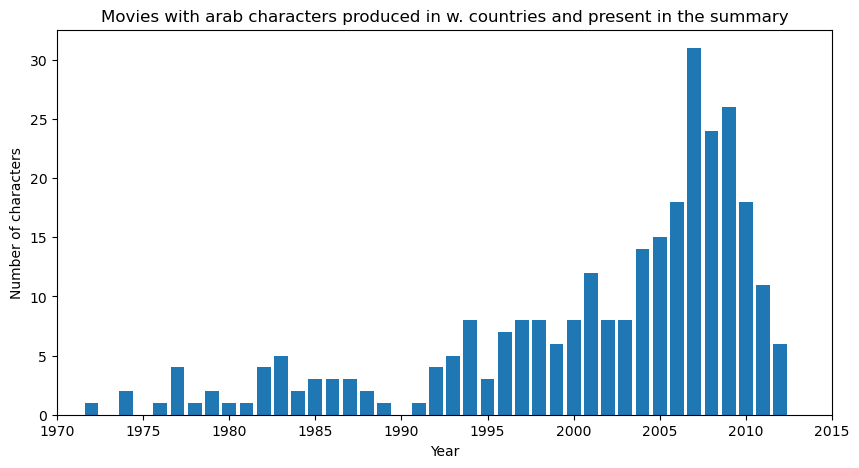

Movies with arab characters present in the summary before 2001: 156
Movies with arab characters present in the summary after 2001: 179


In [127]:
# Plot the yearly number of arab characters in movies pubblished in USA, present in the summary


plt.figure(figsize=(10,5))
yearly_ar_we_movies = movies_ar_western.groupby(movies_ar_western['release_date'].dt.year)['has_arabic_character'].sum().reset_index(name='characters_ar_we_inplot')
plt.bar(yearly_ar_we_movies['release_date'],yearly_ar_we_movies['characters_ar_we_inplot'])
plt.xlim(1970,2015)
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Movies with arab characters produced in w. countries and present in the summary')
plt.show()

print(f'Movies with arab characters present in the summary before 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]<=2001]["characters_ar_we_inplot"].sum()}')
print(f'Movies with arab characters present in the summary after 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]>2001]["characters_ar_we_inplot"].sum()}')